In [24]:
from typing import TypedDict,Literal,Annotated
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
import operator
from langchain_core.messages import SystemMessage, HumanMessage

In [4]:
load_dotenv()

True

In [ ]:
generator_model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
optimizer_model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [30]:
class evaluation_schema(BaseModel):
    evaluation:Literal['Approved','Needs Improvement']=Field(...,description='Evaluation of the generated post')
    feedback:str=Field(...,description='Feedback of the genrated post')
    

In [31]:
evaluator_model=generator_model.with_structured_output(evaluation_schema)

In [32]:
class tweet_schema(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal['Approved','Needs Improvement']
    feedback:str
    iterations:int
    max_iterations:int
    tweet_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]
    

In [33]:
def generate_tweet(state:tweet_schema):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    response=generator_model.invoke(messages).content
    return {'tweet':response,'tweet_history':[response]}

In [34]:
def evaluate_tweet(state:tweet_schema):
     # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "Approved" or "Needs Improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    response=evaluator_model.invoke(messages)
    return {'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history':[response.feedback]}

In [35]:
def optimize_tweet(state:tweet_schema):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    
    response=optimizer_model.invoke(messages).content
    iteration=state['iterations']+1
    return {'tweet':response,'iterations':iteration,'tweet_history':[response]}

In [36]:
def check_evaluation(state:tweet_schema):
    if state['evaluation']=='Approved' or state['iterations']>=state['max_iterations']:
        return 'Approved'
    else:
        return 'Needs Improvement'

In [37]:
graph=StateGraph(tweet_schema)

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('evaluate_tweet',evaluate_tweet)
graph.add_node('optimize_tweet',optimize_tweet)

graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','evaluate_tweet')

graph.add_conditional_edges('evaluate_tweet',check_evaluation,{'Approved':END,'Needs Improvement':'optimize_tweet'})

graph.add_edge('optimize_tweet','evaluate_tweet')

workflow=graph.compile()

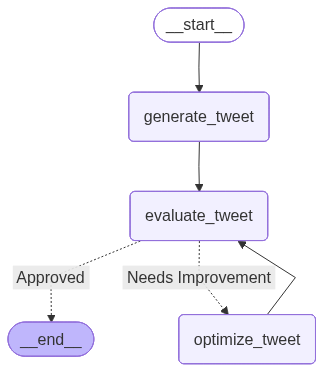

In [38]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [39]:
initial_state = {
    "topic": "srhberhb",
    "iterations": 1,
    "max_iterations": 5
}
result = workflow.invoke(initial_state)

In [40]:
print(result)

{'topic': 'srhberhb', 'tweet': "Here's a revised tweet that aims for originality, humor, and virality:\n\nMy brain: 'srhberhb' on repeat. Current cognitive load is too high for things like *shoes* or *full sentences*. Send coffee & snacks. ☕😵\u200d💫", 'evaluation': 'Approved', 'feedback': "This tweet is effective, original, and genuinely humorous. The 'srhberhb' on repeat perfectly captures the essence of cognitive overload in a uniquely funny way, making it instantly relatable. The escalation to struggling with 'shoes' or 'full sentences' adds a clever layer of relatable exaggeration. Its punchiness, clear format, and excellent use of emojis contribute to its high virality potential, making it very shareable among those who experience similar brain fog.", 'iterations': 4, 'max_iterations': 5, 'tweet_history': ["My brain on Mondays before coffee just defaults to 'srhberhb' and assumes I understand. Honestly, relatable. We're all just trying our best out here.", "Here are a few options,

In [41]:
print(result['tweet_history'])

["My brain on Mondays before coffee just defaults to 'srhberhb' and assumes I understand. Honestly, relatable. We're all just trying our best out here.", "Here are a few options, focusing on humor and conciseness, completely ditching the earnestness and generic tropes:\n\n**Option 1 (Tech Humor):**\nBrain loading... Error: 'srhberhb'. Please insert coffee to continue.\n\n**Option 2 (Exaggerated Lack of Function):**\nMy brain's pre-coffee operating system is just 'srhberhb'. Zero functionality.\n\n**Option 3 (Direct & Punchy):**\nUntil coffee, my brain only speaks 'srhberhb'. Don't ask me anything important.", "Here's a punchy, viral-ready tweet based on your feedback, focusing on the strengths of Option 3:\n\n---\n\nUntil coffee, my brain only speaks 'srhberhb'. Don't even *think* about asking me to adult. ☕🤯", "Here's a revised tweet that aims for originality, humor, and virality:\n\nMy brain: 'srhberhb' on repeat. Current cognitive load is too high for things like *shoes* or *full se

In [42]:
print(result['feedback_history'])

["This tweet barely registers on the humor scale, relying on a tired 'Mondays and coffee' trope that has been overused into oblivion. The random string 'srhberhb' is a weak attempt at originality, and the subsequent 'Honestly, relatable. We're all just trying our best out here.' is a deflating, overly sentimental ending that kills any minuscule punch the tweet might have possessed. It's too long, too generic, and too earnest to be considered genuinely humorous or viral.", "This submission fails immediately on format alone. A tweet cannot be a meta-discussion of 'options' and must adhere to the character limit, which this entirely disregards. While the individual concepts presented (particularly Option 3) showed a glimmer of originality and potential punchiness regarding pre-coffee brain function and 'srhberhb' as a unique gibberish, the overall delivery as a single 'tweet' is entirely unworkable and exceeds Twitter's constraints. Focus on delivering one sharp, concise tweet, not a comm